In [ ]:
# -*- coding: utf-8 -*-
"""JAX-CFD demo.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/github/google/jax-cfd/blob/main/notebooks/demo.ipynb

# JAX-CFD demo

This initial demonstration shows how to use JAX-CFD to simulate decaying turbulence in 2D.
"""


import jax
import jax.numpy as jnp
import jax_cfd.base as cfd
import numpy as np
import seaborn
import xarray

# Commented out IPython magic to ensure Python compatibility.
size = 256
size = 2048
density = 1.
viscosity = 1e-3
seed = 121
inner_steps = 25
outer_steps = 200

max_velocity = 7.0
cfl_safety_factor = 0.5

# Define the physical dimensions of the simulation.
grid = cfd.grids.Grid((size, size), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))

# Construct a random initial velocity. The `filtered_velocity_field` function
# ensures that the initial velocity is divergence free and it filters out
# high frequency fluctuations.
v0 = cfd.initial_conditions.filtered_velocity_field(
    jax.random.PRNGKey(seed), grid, max_velocity)

# Choose a time step.
dt = cfd.equations.stable_time_step(
    max_velocity, cfl_safety_factor, viscosity, grid)

# outer_steps = int(1.5//dt//2)
inner_steps = int(4.5/outer_steps/dt)
print(outer_steps)
print(dt)

# Define a step function and use it to compute a trajectory.
step_fn = cfd.funcutils.repeated(
    cfd.equations.semi_implicit_navier_stokes(
        density=density, viscosity=viscosity, dt=dt, grid=grid),
    steps=inner_steps)
rollout_fn = jax.jit(cfd.funcutils.trajectory(step_fn, outer_steps))
%time _, trajectory = jax.device_get(rollout_fn(v0))

# JAX-CFD uses GridVariable objects for input/output. These objects contain:
#  - array data
#  - an "offset" that documents the position on the unit-cell where the data
#    values are located
#  - grid properties
#  - boundary conditions on the variable
with np.printoptions(edgeitems=1):
  for i, u in enumerate(trajectory):
    print(f'Component {i}: {u}')


200
0.0002191401125550916
CPU times: user 17.9 s, sys: 37.5 s, total: 55.4 s
Wall time: 56.1 s
Component 0: GridVariable(array=GridArray(data=array([[[ 0.685698  , ...,  0.6788758 ],
        ...,
        [ 0.6878456 , ...,  0.68110925]],

       ...,

       [[-0.6496797 , ..., -0.65235406],
        ...,
        [-0.6501726 , ..., -0.65284204]]],
      shape=(200, 2048, 2048), dtype=float32), offset=(1.0, 0.5), grid=Grid(shape=(2048, 2048), step=(0.0030679615757712823, 0.0030679615757712823), domain=((0.0, 6.283185307179586), (0.0, 6.283185307179586)))), bc=HomogeneousBoundaryConditions(types=(('periodic', 'periodic'), ('periodic', 'periodic')), bc_values=((0.0, 0.0), (0.0, 0.0))))
Component 1: GridVariable(array=GridArray(data=array([[[-0.2423912 , ..., -0.24453866],
        ...,
        [-0.22549881, ..., -0.2276134 ]],

       ...,

       [[-0.5940152 , ..., -0.5935222 ],
        ...,
        [-0.59210205, ..., -0.59161335]]],
      shape=(200, 2048, 2048), dtype=float32), offset=(

In [2]:

# load into xarray for visualization and analysis
ds = xarray.Dataset(
    {
        'u': (('time', 'x', 'y'), trajectory[0].data),
        'v': (('time', 'x', 'y'), trajectory[1].data),
    },
    coords={
        'x': grid.axes()[0],
        'y': grid.axes()[1],
        'time': dt * inner_steps * np.arange(outer_steps)
    }
)

ds.to_netcdf("test.nc")



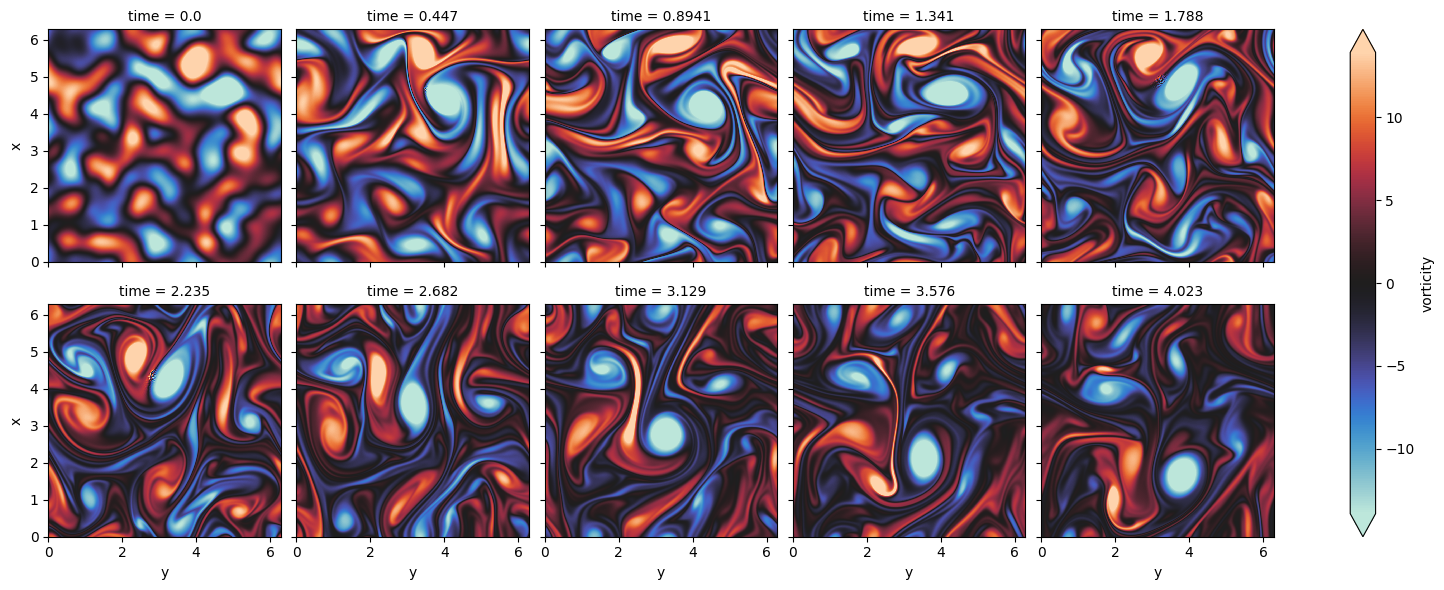

In [3]:

def vorticity(ds):
  return (ds.v.differentiate('x') - ds.u.differentiate('y')).rename('vorticity')

(ds.pipe(vorticity).thin(time=20)
 .plot.imshow(col='time', cmap=seaborn.cm.icefire, robust=True, col_wrap=5));


In [4]:
step = 1
import jax_cfd.base.finite_differences as fd
def p_fake(v,
           q0=None,
           pressure_bc=None,
           implementation=None):
    rhs = fd.divergence(v)
    return cfd.grids.GridArray(np.zeros(q0.shape), rhs.offset, rhs.grid)

step_fn_1step_nop = cfd.funcutils.repeated(
    cfd.equations.semi_implicit_navier_stokes(
        density=density, viscosity=viscosity, dt=dt, grid=grid, pressure_solve=p_fake),
    steps=step)
step_fn_1step = cfd.funcutils.repeated(
    cfd.equations.semi_implicit_navier_stokes(
        density=density, viscosity=viscosity, dt=dt, grid=grid),
    steps=step)



v1_nop = step_fn_1step_nop(v0)
v1 = step_fn_1step(v0)

# from jax_cfd.base import finite_differences as fd

# divergence = fd.divergence(v1)
# print(v1[0].shape)
# # dudx = (np.roll(v1[0].data,-1,axis=-2) - np.roll(v1[0].data,1,axis=-2))/(ds.x[1]-ds.x[0]).data/2
# # dvdy = (np.roll(v1[1].data,-1,axis=-1) - np.roll(v1[1].data,1,axis=-1))/(ds.y[1]-ds.y[0]).data/2
# # dudx = (np.roll(v1[0].data,-1,axis=-2) - v1[0].data)/(ds.x[1]-ds.x[0]).data
# # dvdy = (np.roll(v1[1].data,-1,axis=-1) - v1[1].data)/(ds.y[1]-ds.y[0]).data

# dudx = (np.roll(v1[0].data,1,axis=-2) - v1[0].data)/(ds.x[1]-ds.x[0]).data
# dvdy = (np.roll(v1[1].data,1,axis=-1) - v1[1].data)/(ds.y[1]-ds.y[0]).data
# # dudx = (np.roll(v1[0].data,-1,axis=-2) - v1[0].data)/(ds.x[1]-ds.x[0]).data
# # dvdy = (np.roll(v1[1].data,-1,axis=-1) - v1[1].data)/(ds.y[1]-ds.y[0]).data
# divergence_calc = dudx+dvdy
# print(divergence)
# print(divergence_calc)
# print(divergence.data.std())
# print(divergence_calc.std())

# v = v1
# grid = cfd.grids.consistent_grid(*v)
# if len(v) != grid.ndim:
#   raise ValueError('The length of `v` must be equal to `grid.ndim`.'
#                     f'Expected length {grid.ndim}; got {len(v)}.')
# differences = [fd.backward_difference(u, axis) for axis, u in enumerate(v)]
# # differences = [fd.central_difference(u, axis) for axis, u in enumerate(v)]

# divergence = sum(differences)
# # divergence = fd.centered_divergence(v1)
# divergence_calc = dudx+dvdy
# difference_1 = dudx - differences[0].data
# difference_2 = dvdy - differences[1].data

# # print(dudx)
# # print(differences[0])
# # print(dvdy)
# # print(differences[1])

# # print(np.abs(difference_1).shape)
# location = np.unravel_index(np.argmax(np.abs(difference_1)), difference_1.shape)
# # print(difference_1.min())
# print(location)
# # print(difference_1[164:168,212:216])
# # print(difference_1[100:170,212:216])
# print(dudx[100:170,214])
# print(differences[0].data[100:170,214])


# print(divergence)
# print(divergence_calc)
# print(np.abs(divergence.data).max())
# print(np.abs(dudx+dvdy).max())

dudt_nop = (v1_nop[0].data - v0[0].data)/(dt*step)
dudt = (v1[0].data - v0[0].data)/(dt*step)
uu = v0[0].data**2
uv = v0[0].data*v0[1].data
duudx = (np.roll(uu,1,-2) - uu)/(ds.x[1]-ds.x[0]).data
duvdy = (np.roll(uv,1,-1) - uv)/(ds.y[1]-ds.y[0]).data
duudx = (np.gradient(uu,axis=-2))/(ds.x[1]-ds.x[0]).data
duvdy = (np.gradient(uv,axis=-1))/(ds.y[1]-ds.y[0]).data
conv = duudx + duvdy
residual = dudt + conv
ratio = conv/(dudt+1e-4)
# print(conv)

print(dudt)
print(dudt_nop)

# print(residual)
# print(dudt)
# print(conv)
print('dudt metrics')
print(np.abs(dudt).mean())
print(np.abs(dudt).max())
print(np.std(dudt))

print('dudt nop metrics')
print(np.abs(dudt_nop).mean())
print(np.abs(dudt_nop).max())
print(np.std(dudt_nop))

# print(dudt.std())
print('residual metrics')
print(np.abs(residual).mean())
print(np.abs(residual).max())
print(np.std(residual))
print('ratio metrics')
print(np.abs(ratio).mean())
print(np.abs(ratio).max())
print(np.std(ratio))

[[0.5861456  0.60300916 0.6187848  ... 0.53093094 0.55051446 0.568738  ]
 [0.57880175 0.59539336 0.61062497 ... 0.5246751  0.5434426  0.5616662 ]
 [0.57200193 0.58804953 0.60328114 ... 0.51787525 0.5369148  0.5548664 ]
 ...
 [0.61307293 0.6302085  0.6465281  ... 0.5567703  0.5760818  0.5951214 ]
 [0.60328114 0.6201447  0.63592035 ... 0.54670656 0.56656206 0.5853296 ]
 [0.59484935 0.61144096 0.62748855 ... 0.53909075 0.5586743  0.5771698 ]]
[[0.7471656  0.7183343  0.689503   ... 0.83229953 0.8042842  0.77572495]
 [0.7972124  0.7681091  0.73791784 ... 0.88533825 0.85623497 0.8271316 ]
 [0.8483471  0.8176119  0.78714865 ... 0.93864894 0.9087297  0.87853837]
 ...
 [0.5997453  0.5736339  0.54725057 ... 0.67699134 0.65088    0.6253126 ]
 [0.64816004 0.62123275 0.5940334  ... 0.7278541  0.70174277 0.6750874 ]
 [0.69739085 0.6696475  0.6416322  ... 0.7800768  0.7526055  0.7251342 ]]
dudt metrics
3.3171427
28.163683
4.9643145
dudt nop metrics
5.4299097
68.37994
8.773354
residual metrics
4.63214

In [5]:
# divergence
from jax_cfd.base import finite_differences as fd

divergence = fd.divergence(v1)
# print(v1[0].shape)
# dudx = (np.roll(v1[0].data,-1,axis=-2) - np.roll(v1[0].data,1,axis=-2))/(ds.x[1]-ds.x[0]).data/2
# dvdy = (np.roll(v1[1].data,-1,axis=-1) - np.roll(v1[1].data,1,axis=-1))/(ds.y[1]-ds.y[0]).data/2
# dudx = (np.roll(v1[0].data,-1,axis=-2) - v1[0].data)/(ds.x[1]-ds.x[0]).data
# dvdy = (np.roll(v1[1].data,-1,axis=-1) - v1[1].data)/(ds.y[1]-ds.y[0]).data

dudx = (np.roll(v1[0].data,1,axis=-2) - v1[0].data)/(ds.x[1]-ds.x[0]).data
dvdy = (np.roll(v1[1].data,1,axis=-1) - v1[1].data)/(ds.y[1]-ds.y[0]).data
# dudx = (np.roll(v1[0].data,-1,axis=-2) - v1[0].data)/(ds.x[1]-ds.x[0]).data
# dvdy = (np.roll(v1[1].data,-1,axis=-1) - v1[1].data)/(ds.y[1]-ds.y[0]).data
divergence_calc = dudx+dvdy
print('divergence from jax cfd')
print(divergence)
print(divergence.data.std())
print('calculated divergences using np')
print(divergence_calc)
print(divergence_calc.std())

# v = v1
# grid = cfd.grids.consistent_grid(*v)
# if len(v) != grid.ndim:
#   raise ValueError('The length of `v` must be equal to `grid.ndim`.'
#                     f'Expected length {grid.ndim}; got {len(v)}.')
# differences = [fd.backward_difference(u, axis) for axis, u in enumerate(v)]
# # differences = [fd.central_difference(u, axis) for axis, u in enumerate(v)]

# divergence = sum(differences)
# # divergence = fd.centered_divergence(v1)
# divergence_calc = dudx+dvdy
# difference_1 = dudx - differences[0].data
# difference_2 = dvdy - differences[1].data

# # print(dudx)
# # print(differences[0])
# # print(dvdy)
# # print(differences[1])

# # print(np.abs(difference_1).shape)
# location = np.unravel_index(np.argmax(np.abs(difference_1)), difference_1.shape)
# # print(difference_1.min())
# print(location)
# # print(difference_1[164:168,212:216])
# # print(difference_1[100:170,212:216])
# print(dudx[100:170,214])
# print(differences[0].data[100:170,214])


# print(divergence)
# print(divergence_calc)
# print(np.abs(divergence.data).max())
# print(np.abs(dudx+dvdy).max())


divergence from jax cfd
GridArray(data=Array([[-3.40342522e-05,  0.00000000e+00, -1.46031380e-05, ...,
        -3.40342522e-05, -9.71555710e-06, -1.94311142e-05],
       [ 4.85777855e-05,  0.00000000e+00,  2.42590904e-05, ...,
         1.45435333e-05,  2.91466713e-05, -3.88622284e-05],
       [-9.71555710e-06,  2.43186951e-05, -1.45435333e-05, ...,
        -1.45435333e-05,  2.43186951e-05,  9.71555710e-06],
       ...,
       [ 7.04526901e-05, -1.69873238e-05,  9.22679901e-05, ...,
        -4.37498093e-05,  1.33514404e-04, -4.61935997e-05],
       [ 1.21593475e-05, -5.10215759e-05, -9.71555710e-06, ...,
        -1.21474266e-04,  2.44379044e-06, -8.73804092e-05],
       [ 5.82933426e-05, -4.82797623e-06,  5.34057617e-05, ...,
        -2.42590904e-05,  9.71555710e-05, -2.91466713e-05]],      dtype=float32), offset=(0.5, 0.5), grid=Grid(shape=(2048, 2048), step=(0.0030679615757712823, 0.0030679615757712823), domain=((0.0, 6.283185307179586), (0.0, 6.283185307179586))))
5.9503847e-05
calcu

In [ ]:
# v1 = _

# downsample
from typing import Tuple
u = v1[0].data
v = v1[1].data

# u = ds.u.data[-1]
# v = ds.v.data[-1]

# interpolate to node center velocities
u = 0.5*(np.roll(u,1,axis=-2) + u)
v = 0.5*(np.roll(v,1,axis=-1) + v)

# downsample with kernel
downsample_size = 2048//64
kernel = np.ones((downsample_size,downsample_size))/downsample_size

def downsample_by_averaging(img: np.ndarray, window_shape: Tuple[int, int]) -> np.ndarray:
    return np.mean(
        img.reshape((
            *img.shape[:-2],
            img.shape[-2] // window_shape[-2], window_shape[-2],
            img.shape[-1] // window_shape[-1], window_shape[-1],
        )),
        axis=(-1, -3),
    )

downsampled_u = downsample_by_averaging(u,[downsample_size,downsample_size])
downsampled_v = downsample_by_averaging(v,[downsample_size,downsample_size])

def downsample_faces(u,v,size=64):
    tmp_u = u[:,::size]
    tmp_u = tmp_u.reshape(tmp_u.shape[-2]//size,size,tmp_u.shape[-1])
    tmp_u = tmp_u.mean(-2)
    tmp_v = v[::size,:]
    tmp_v = tmp_v.reshape(tmp_v.shape[-2],tmp_v.shape[-1]//size,size)
    tmp_v = tmp_v.mean(-1)
    return tmp_u,tmp_v

# downsampled_u = downsample_faces(u,64)
# downsampled_v = downsample_faces(v,64)
# downsampled_u,downsampled_v = downsample_faces(u,v,2)

# downsampled_v = v[::downsample_size,::downsample_size]

from jax_cfd.base.resize import *
grid_down = cfd.grids.Grid((64, 64), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))
# jax_downsample = downsample_staggered_velocity(grid,grid_down,v1)
# jax_downsample = downsample_staggered_velocity_component(v1[0],0,32), downsample_staggered_velocity_component(v1[1],1,32)

# check divergences on downsampled values
dudx = (np.roll(downsampled_u,1,axis=-2) - np.roll(downsampled_u,-1,axis=-2))/(ds.x[1]-ds.x[0]).data/2
dvdy = (np.roll(downsampled_v,1,axis=-1) - np.roll(downsampled_v,-1,axis=-1))/(ds.y[1]-ds.y[0]).data/2


# dudx = (np.roll(v1[0].data,-1,axis=-2) - v1[0].data)/(ds.x[1]-ds.x[0]).data
# dvdy = (np.roll(v1[1].data,-1,axis=-1) - v1[1].data)/(ds.y[1]-ds.y[0]).data

# dudx = (np.roll(downsampled_u,1,axis=-2) - downsampled_u)/(ds.x[1]-ds.x[0]).data
# dvdy = (np.roll(downsampled_v,1,axis=-1) - downsampled_v)/(ds.y[1]-ds.y[0]).data

divergence_calc = dudx+dvdy
print('divergence from jax cfd')
print(divergence)
print(divergence.data.std())
print('calculated divergences using np')
print(divergence_calc)
print(divergence_calc.std())


divergence from jax cfd
GridArray(data=Array([[-3.40342522e-05,  0.00000000e+00, -1.46031380e-05, ...,
        -3.40342522e-05, -9.71555710e-06, -1.94311142e-05],
       [ 4.85777855e-05,  0.00000000e+00,  2.42590904e-05, ...,
         1.45435333e-05,  2.91466713e-05, -3.88622284e-05],
       [-9.71555710e-06,  2.43186951e-05, -1.45435333e-05, ...,
        -1.45435333e-05,  2.43186951e-05,  9.71555710e-06],
       ...,
       [ 7.04526901e-05, -1.69873238e-05,  9.22679901e-05, ...,
        -4.37498093e-05,  1.33514404e-04, -4.61935997e-05],
       [ 1.21593475e-05, -5.10215759e-05, -9.71555710e-06, ...,
        -1.21474266e-04,  2.44379044e-06, -8.73804092e-05],
       [ 5.82933426e-05, -4.82797623e-06,  5.34057617e-05, ...,
        -2.42590904e-05,  9.71555710e-05, -2.91466713e-05]],      dtype=float32), offset=(0.5, 0.5), grid=Grid(shape=(2048, 2048), step=(0.0030679615757712823, 0.0030679615757712823), domain=((0.0, 6.283185307179586), (0.0, 6.283185307179586))))
5.9503847e-05
calcu

In [7]:
cmap=seaborn.cm.icefire, robust=True, col_wrap=5));

step_fn_1step = cfd.funcutils.repeated(
    cfd.equations.semi_implicit_navier_stokes(
        density=density, viscosity=viscosity, dt=dt, grid=grid),
    steps=1)

v1 = step_fn_1step(v0)

from jax_cfd.base import finite_differences as fd

divergence = fd.divergence(v1)
print(v1[0].shape)
# dudx = (np.roll(v1[0].data,-1,axis=-2) - np.roll(v1[0].data,1,axis=-2))/(ds.x[1]-ds.x[0]).data/2
# dvdy = (np.roll(v1[1].data,-1,axis=-1) - np.roll(v1[1].data,1,axis=-1))/(ds.y[1]-ds.y[0]).data/2
# dudx = (np.roll(v1[0].data,-1,axis=-2) - v1[0].data)/(ds.x[1]-ds.x[0]).data
# dvdy = (np.roll(v1[1].data,-1,axis=-1) - v1[1].data)/(ds.y[1]-ds.y[0]).data

dudx = (np.roll(v1[0].data,1,axis=-2) - v1[0].data)/(ds.x[1]-ds.x[0]).data
dvdy = (np.roll(v1[1].data,1,axis=-1) - v1[1].data)/(ds.y[1]-ds.y[0]).data
# dudx = (np.roll(v1[0].data,-1,axis=-2) - v1[0].data)/(ds.x[1]-ds.x[0]).data
# dvdy = (np.roll(v1[1].data,-1,axis=-1) - v1[1].data)/(ds.y[1]-ds.y[0]).data
divergence_calc = dudx+dvdy
print(divergence)
print(divergence_calc)
print(divergence.data.std())
print(divergence_calc.std())

v = v1
grid = cfd.grids.consistent_grid(*v)
if len(v) != grid.ndim:
  raise ValueError('The length of `v` must be equal to `grid.ndim`.'
                    f'Expected length {grid.ndim}; got {len(v)}.')
differences = [fd.backward_difference(u, axis) for axis, u in enumerate(v)]
# differences = [fd.central_difference(u, axis) for axis, u in enumerate(v)]

divergence = sum(differences)
# divergence = fd.centered_divergence(v1)
divergence_calc = dudx+dvdy
difference_1 = dudx - differences[0].data
difference_2 = dvdy - differences[1].data

# print(dudx)
# print(differences[0])
# print(dvdy)
# print(differences[1])

# print(np.abs(difference_1).shape)
location = np.unravel_index(np.argmax(np.abs(difference_1)), difference_1.shape)
# print(difference_1.min())
print(location)
# print(difference_1[164:168,212:216])
# print(difference_1[100:170,212:216])
print(dudx[100:170,214])
print(differences[0].data[100:170,214])


print(divergence)
print(divergence_calc)
print(np.abs(divergence.data).max())
print(np.abs(dudx+dvdy).max())


SyntaxError: unmatched ')' (3644911193.py, line 1)